# CUDA UFuncs and memory management

In this notebook you wil learn how to GPU accelerate element-wise NumPy array functions by compiling [NumPy Universal functions \(or ufuncs\)](https://docs.scipy.org/doc/numpy-1.15.1/reference/ufuncs.html) for the GPU, along with some techniques for efficiently moving data between a CPU host and GPU device.

## Objectives for this Section

By the time you complete this section you will be able to:

- GPU accelerate NumPy ufuncs.
- GPU accelerate hand-written vectorized functions.
- Optimize data transfers between the CPU host and GPU device.

## Review of NumPy Universal Functions (ufuncs)

NumPy has the concept of universal functions ("ufuncs"), which are functions that can take NumPy arrays of varying dimensions, or scalars, and operate on them element-by-element.

As an example we'll use the NumPy `add` ufunc to demonstrate the basic ufunc mechanism:

In [1]:
import numpy as np

a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])

np.add(a, b)

array([11, 22, 33, 44])

Ufuncs also can combine scalars with arrays:

In [2]:
np.add(a, 100)

array([101, 102, 103, 104])

Arrays of different, but compatible dimensions can also be combined. The lower dimensional array will be replicated to match the dimensionality of the higher dimensional array.

In [3]:
c = np.arange(4*4).reshape((4,4))
print('c:', c)

np.add(b, c)

c: [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([[10, 21, 32, 43],
       [14, 25, 36, 47],
       [18, 29, 40, 51],
       [22, 33, 44, 55]])

## Making ufuncs for the GPU

Numba has the ability to create *compiled* ufuncs. You simply implement a scalar function to be performed on all the inputs, decorate it with `@vectorize`, and Numba will figure out the broadcast rules for you.

Generating a ufunc that uses CUDA requires giving an **explicit type signature** and setting the `target` attribute. The type signature argument describes what types to use both for the ufuncs arguments and return value:
```python
'return_value_type(argument1_value_type, argument2_value_type, ...)'
```

See the Numba docs for more on [available types](https://numba.readthedocs.io/en/stable/reference/types.html), as well as for additional information on [writing ufuncs with more than one signature](https://numba.readthedocs.io/en/stable/user/vectorize.html)

This example defines a ufunc that expects two `int64` values and returns an `int64` value, and is compiled for a CUDA device:

In [4]:
from numba import vectorize

@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [5]:
add_ufunc(a, b)

array([11, 22, 33, 44])

A lot of things just happened!  Numba just automatically:

 * Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements.
 * Allocated GPU memory for the inputs and the output.
 * Copied the input data to the GPU.
 * Executed the CUDA kernel (GPU function) with the correct kernel dimensions given the input sizes.
 * Copied the result back from the GPU to the CPU.
 * Returned the result as a NumPy array on the host.
 
Compared to an implementation in C, the above is remarkably more concise.

You might be wondering how fast our simple example is on the GPU?  Let's see:

In [6]:
%timeit np.add(b, c)   # NumPy on CPU

1.33 µs ± 8.27 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [7]:
%timeit add_ufunc(b, c) # Numba on GPU

1.41 ms ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Wow, the GPU is *a lot slower* than the CPU?? For the time being this is to be expected because we have (deliberately) misused the GPU in several ways in this example:

  * **Our inputs are too small**: the GPU achieves performance through parallelism, operating on thousands of values at once.  Our test inputs have only 4 and 16 integers, respectively.  We need a much larger array to even keep the GPU busy.
  * **Our calculation is too simple**: Sending a calculation to the GPU involves quite a bit of overhead compared to calling a function on the CPU.  If our calculation does not involve enough math operations (often called "arithmetic intensity"), then the GPU will spend most of its time waiting for data to move around.
  * **We copy the data to and from the GPU**: While in some scenarios, paying the cost of copying data to and from the GPU can be worth it for a single function, often it will be preferred to to run several GPU operations in sequence. In those cases, it makes sense to send data to the GPU and keep it there until all of our processing is complete.
  * **Our data types are larger than necessary**: Our example uses `int64` when we probably don't need it.  Scalar code using data types that are 32 and 64-bit run basically the same speed on the CPU, and for integer types the difference may not be drastic, but 64-bit floating point data types have a significant performance cost on the GPU.  Basic arithmetic on 64-bit floats can be anywhere from 2x (Pascal-architecture Tesla) to 24x (Maxwell-architecture GeForce) slower than 32-bit floats.  NumPy defaults to 64-bit data types when creating arrays, so it is important to set the [`dtype`](https://docs.scipy.org/doc/numpy-1.14.0/reference/arrays.dtypes.html) attribute or use the [`ndarray.astype()`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.astype.html) method to pick 32-bit types when you need them.
  
  
Given the above, let's try an example that is faster on the GPU by performing an operation with much greater arithmetic intensity, on a much larger input, and using a 32-bit data type:

In [8]:
import math # Note that for the CUDA target, we need to use the scalar functions from the math module, not NumPy

SQRT_2PI = np.float32((2*math.pi)**0.5)  # Precompute this constant as a float32.  Numba will inline it at compile time.

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [9]:
import numpy as np
# Evaluate the Gaussian a million times!
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Quick test on a single element just to make sure it works
gaussian_pdf(x[0], 0.0, 1.0)

array([0.36708465], dtype=float32)

In [10]:
import scipy.stats # for definition of gaussian distribution, so we can compare CPU to GPU time
norm_pdf = scipy.stats.norm
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)

40 ms ± 42.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%timeit gaussian_pdf(x, mean, sigma)

4.14 ms ± 32.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's a pretty large improvement, even including the overhead of copying all the data to and from the GPU.  Ufuncs that use special functions (`exp`, `sin`, `cos`, etc) on large data sets run especially well on the GPU.

## CUDA Device Functions

Ufuncs are great, but you should not have to cram all of your logic into a single function body. `@njit` can be used to decorate a helper function that can be utilized by GPU-accelerated ufuncs:

In [12]:
from numba import njit

@njit
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1) # We can use device functions inside our GPU ufuncs
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

In [13]:
n = 1000000
rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)

In [14]:
polar_distance(rho1, theta1, rho2, theta2)

array([0.46352127, 1.098057  , 1.2079104 , ..., 1.9179438 , 0.7772354 ,
       0.3507276 ], dtype=float32)

Note that the CUDA compiler aggressively inlines device functions, so there is generally no overhead for function calls.  Similarly, the "tuple" returned by `polar_to_cartesian` is not actually created as a Python object, but represented temporarily as a struct, which is then optimized away by the compiler.

### Exercise: GPU Accelerate a Function

Let's build a "zero suppression" function. A common operation when working with waveforms is to force all sample values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. Let's make some sample data:

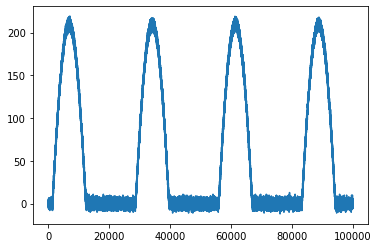

In [15]:
# This allows us to plot right here in the notebook
%matplotlib inline

# Hacking up a noisy pulse train
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

Now decorate this `zero_suppress` function to run as a vectorized ufunc on the CUDA device.

In [16]:
def zero_suppress(waveform_value, threshold):
    if waveform_value < threshold:
        result = 0
    else:
        result = waveform_value
    return result

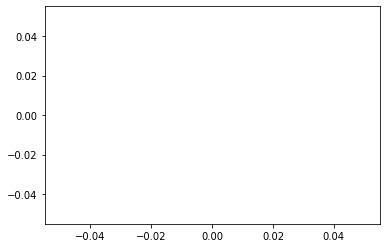

In [17]:
# This will throw an error until you successfully vectorize the `zero_suppress` function above.
# The noise on the baseline should disappear when zero_suppress is implemented
plt.plot(zero_suppress(waveform.any(), 15))

## Managing GPU Memory

During the benchmarking above, we used NumPy arrays on the CPU as inputs and outputs. If you want to reduce the impact of host-to-device/device-to-host bandwidth, it is best to copy data to the GPU explicitly and leave it there to amortize the cost over multiple function calls. In addition, allocating device memory can be relatively slow, so allocating GPU arrays once and refilling them with data from the host can also be a performance improvement.

To demonstrate, let's create our example addition ufunc again:

In [18]:
@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [19]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x

In [20]:
%timeit add_ufunc(x, y)  # Baseline performance with host arrays

1.86 ms ± 6.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The `numba.cuda` module includes a function that will copy host data to the GPU and return a CUDA device array:

In [21]:
from numba import cuda

x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


Device arrays can be passed to CUDA functions just like NumPy arrays, but without the copy overhead:

In [22]:
%timeit add_ufunc(x_device, y_device)

663 µs ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Because `x_device` and `y_device` are already on the device, this benchmark is much faster.

That's a big performance improvement already, but we are still allocating a device array for the output of the ufunc and copying it back to the host. We can create an output array with the [`numba.cuda.device_array()`](https://numba.readthedocs.io/en/stable/cuda-reference/memory.html#numba.cuda.device_array) function:

In [23]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, like np.empty()

And then we can use a special `out` keyword argument to the ufunc to specify the output buffer:

In [24]:
%timeit add_ufunc(x_device, y_device, out=out_device)

406 µs ± 1.87 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This call to `add_ufunc` does not involve any data transfers between the host and device and therefore runs the fastest. If and when we want to bring a device array back to the host memory, we can use the `copy_to_host()` method:

In [25]:
out_host = out_device.copy_to_host()
print(out_host[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


Numba provides additional methods for managing device memory and data transfer. See the [CUDA Memory Management documentation](https://numba.pydata.org/numba-doc/dev/cuda/memory.html) for full details.

### Exercise: Optimize Memory Movement

Given these ufuncs:

In [26]:
import math

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

Convert this code to use device allocations so that there are only host<->device copies at the beginning and end and benchmark performance change:

In [27]:
pulses = make_pulses(t, period, 100.0)
waveform = add_ufunc(pulses, noise)

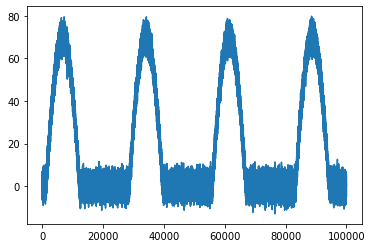

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(waveform)

## Summary

Now that you have completed this session you are able to:

- GPU accelerate NumPy ufuncs
- GPU accelerate hand-written vectorized functions
- Optimize memory transfers between the CPU host and GPU device

## Appendix: Generalized Ufuncs

Ufuncs apply a function on scalar values of an array. Generalized Ufuncs (or *gufuncs*) can operate on inputs that are sub-arrays of an input array.

To build a gufunc, we use the `@guvectorize` decorator. This decorator needs several things:

* A list of signatures. Signatures are similar to ufunc signatures, but the dimension of each argument also needs to be given using a comma-separated list of colons.
* A layout specification. This is a string that gives the relationships between the shapes of the inputs and outputs. Input shapes are given before the `->`, and outputs after it.
* The `target` kwarg, if the gufunc is to run on a CUDA GPU.

Instead of returning an output, the output for a gufunc is passed in.

The following example computes the moving mean of sub-arrays of a 2D matrix:

In [29]:
from numba import guvectorize, float64, int64

# Moving mean example
@guvectorize([(float64[:], int64[:], float64[:])], '(n),()->(n)', target='cuda')
def move_mean(a, window_arr, out):
    window_width = window_arr[0]
    asum = 0.0
    count = 0
    for i in range(window_width):
        asum += a[i]
        count += 1
        out[i] = asum / count
    for i in range(window_width, len(a)):
        asum += a[i] - a[i - window_width]
        out[i] = asum / count

arr = np.arange(20, dtype=np.float64).reshape(2, 10)
move_mean(arr, 3)

array([[ 0. ,  0.5,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ],
       [10. , 10.5, 11. , 12. , 13. , 14. , 15. , 16. , 17. , 18. ]])

Further reading on gufuncs:

* [Generalized Universal Function API documentation](http://docs.scipy.org/doc/numpy/reference/c-api.generalized-ufuncs.html)
* [Numba guvectorize decorator documentation](https://numba.readthedocs.io/en/stable/user/vectorize.html#the-guvectorize-decorator)
* [Numba CUDA guvectorize documentation](https://numba.readthedocs.io/en/stable/cuda/ufunc.html#generalized-cuda-ufuncs)